In [82]:
import pandas as pd
import seaborn as sn
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

def compute_score(clf, X, y):
    xval = cross_val_score(clf, X, y, cv=5)
    return np.mean(xval)

# Réponse TP2
## HEBAN Simon

# Partie 1 : les données


In [53]:
train = pd.read_csv('data/titanic_train.csv', sep=',')
pd.set_option('display.max_columns', None)
print(train.head(10))
train.set_index('PassengerId', inplace=True, drop=True)
print(train.columns)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

#### Question 3

- Survived : La personne à t'elle survécu type booléen (0=non;1=oui)
- PClass : Classe de la personne
  - 1 : Première classe
  - 2 : Seconde classe
  - 3 : Troisème classe
- Name : Nom sur le ticket
- Sex : Male ou female
- Age: Age (Possiblement NaN)
- SibSp : Nombre de frères et sœurs / conjoints à bord
- Parch : Nombre de parents / enfants à bord du Titanic
- Ticket : Numéro du ticket
- Fare : Tarif passager
- Cabin : Numéro de cabine (possiblement Nan)
- Embarked : Port d'embarquement
  - C = Cherbourg
  - Q = Queenstown
  - S = Southampton

# Partie 2 : Premier modèle de niveau 0

In [54]:
def parse_model_0(X):
    target = X.Survived
    X = X[['Fare', 'SibSp', 'Parch']]
    return X, target

train = pd.read_csv('data/titanic_train.csv', sep=',')
pd.set_option('display.max_columns', None)
print(train.head(10))
train.set_index('PassengerId', inplace=True, drop=True)
print(train.columns)

X, y = parse_model_0(train.copy())
print("Moyenne des scores de la régression logistique : ", compute_score(LogisticRegression(), X,y))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

## Question 2

Nous utilisons la validation croisée, car l'échantillon de données est trop faible. On ne pourrait pas prendre N données pour apprendre et Y données pour tester, parce qu'on se retrouverait avec trop peu de données.

# Partie 3 : Deuxième modèle

In [55]:
train = pd.read_csv('data/titanic_train.csv', sep=',')
train.set_index('PassengerId', inplace=True, drop=True)
survived = train[train.Survived == 1]
dead = train[train.Survived == 0]

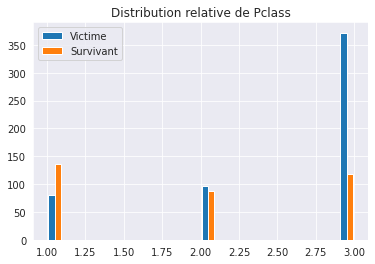

In [56]:
def plot_hist(feature, bins=20):
    x1 = np.array(dead[feature].dropna())
    x2 = np.array(survived[feature].dropna())
    plt.hist([x1, x2], label=['Victime', 'Survivant'], bins=bins)
    plt.legend(loc='upper left')
    plt.title('Distribution relative de %s' % feature)
    plt.show()

plot_hist('Pclass')

## Question 3
La variable PClass semble être importante, elle montre que la 3ᵉ classe a subi beaucoup plus de perte que les autres. Elle parait néanmoins moins utile pour discriminer les catégories 1 et 2.

In [57]:
def parse_model_1(X):
    target = X.Survived
    class_dummies = pd.get_dummies(X['Pclass'], prefix='split_Pclass')
    X = X.join(class_dummies)
    to_del = ['Name', 'Age', 'Cabin', 'Embarked', 'Survived', 'Ticket', 'Sex', 'Pclass']
    for col in to_del :
        del X[col]
    return X, target

In [58]:
lr = LogisticRegression(max_iter=10000)
X,y = parse_model_1(train)
lr.fit(X,y)
print(compute_score(lr,X,y))

0.6937040989266211


#### Question 5

On constate que la moyenne des scores est sensiblement la même que pour le résultat d'avant. Ceci s'explique par le fait que nous venons de retirer des données qui n'étaient pas importantes (non correlé avec la variable cible).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


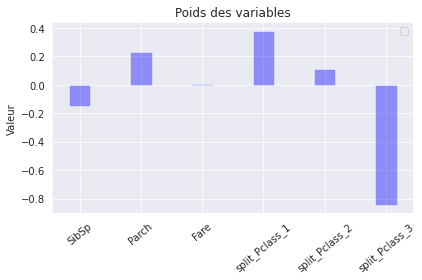

In [59]:
def plot_lr_coefs(X, lr: LogisticRegression):
    fig, ax = plt.subplots()

    xlabels = X.columns.values.tolist()
    yvalues = lr.coef_[0,]
    index = np.arange(len(yvalues))

    bar_width = 0.35
    opacity = 0.4
    rects = plt.bar(index, yvalues, bar_width, alpha=opacity, color='b', label='')
    plt.ylabel('Valeur')
    plt.title('Poids des variables')
    plt.xticks(index, xlabels, rotation=40)

    plt.legend()
    plt.tight_layout()
    plt.show()

plot_lr_coefs(X,lr)

## Question 6
On constate ici que `split_Pclass_3` à une influence négative sur le fait de survivre. On constate par ailleurs que le coût du ticket (Fare) n'a aucune influence sur le fait de survivre ou non, tout comme le numéro de passager (PassengerId).
D'un autre côté la variable `split_Pclass_1` montre qu'on avait plus de chance de survivre si l'on faisait partie de la première classe.

# Partie 4 : Troisième modèle

In [60]:
def parse_model_2(X):
    X.Age = X.Age.fillna(np.nanmedian(X["Age"]))
    target = X['Survived']
    class_dummies = pd.get_dummies(X['Sex'], prefix='split_Sexe')
    X = X.join(class_dummies)
    class_dummies = pd.get_dummies(X['Pclass'], prefix='split_Pclass')
    X = X.join(class_dummies)
    to_del = ['Name', 'Cabin', 'Embarked', 'Survived', 'Ticket', 'Sex', 'Pclass']
    for col in to_del :
        del X[col]
    return X,target

train = pd.read_csv('data/titanic_train.csv', sep=',')
train.set_index('PassengerId', inplace=True, drop=True)
lr = LogisticRegression(max_iter=10000)
X,y = parse_model_2(train)
lr.fit(X,y)
print(compute_score(lr,X,y))

0.7867553825874083


## Question 3
On constate ici que l'on a plus de chance de survivre si l'on est dans la catégorie 'Female' et que l'on a moins de chance de survivre si l'on est un homme.
"Les femmes et les enfants d'abord".

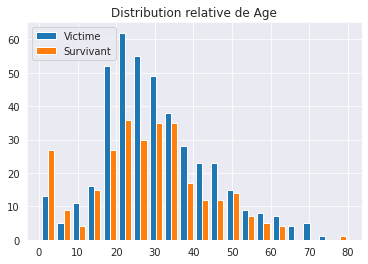

In [61]:
plot_hist('Age')

## Question 4
On constate sur cet histogramme que la tranche des [20-45] ans est la tranche où il y a eu beaucoup plus de victime. Ce nouveau modèle permettra donc de sortir des prédictions plus précises

In [62]:
X['is_child'] = X['Age'] < 8

In [63]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X,y)
print(compute_score(lr, X,y))

0.7990961019396147


# Question 5

Comme attendu l'avenue de cette variable permet de discriminer encore plus entre les survivants et les morts. Car comme on l'a montré dans la question 4, les enfants ont plus de chance de survivre.

# Partie 5 : Selection de variable

In [64]:
data = pd.read_csv('data/titanic_train.csv', sep=',')
data.set_index('PassengerId', inplace=True, drop=True)

def fix_missing_value(data):
    X = data.copy()
    X['Age'] = X['Age'].fillna(np.nanmedian(X['Age']))
    class_dummies = pd.get_dummies(X['Sex'], prefix='split_Sexe')
    X = X.join(class_dummies)
    class_dummies = pd.get_dummies(X['Pclass'], prefix='split_Pclass')
    X = X.join(class_dummies)
    X['is_child'] = X.Age < 8
    return X

data = fix_missing_value(data)
print(data.columns)
criteria = ['Age', 'SibSp', 'Parch', 'Fare', 'split_Pclass_1', 'split_Pclass_2',
            'split_Pclass_3', 'split_Sexe_female', 'split_Sexe_male', 'is_child']

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'split_Sexe_female', 'split_Sexe_male',
       'split_Pclass_1', 'split_Pclass_2', 'split_Pclass_3', 'is_child'],
      dtype='object')


In [65]:
def parse_model_3(X, keepColumns):
    target = X['Survived']
    to_del = [x for x in X.columns if x not in keepColumns]
    for col in to_del:
        del X[col]
    return X, target

def recursive_test(num_vars: int, train, local_criteria, keepColumns=[]):
    if len(keepColumns) >= num_vars:
        X, y = parse_model_3(train.copy(), keepColumns)
        lr = LogisticRegression(max_iter=2000)
        lr.fit(X, y)
        score = compute_score(lr, X, y)
        return score, keepColumns
    highestScore = (0, [])
    for colX in local_criteria:
        if colX not in keepColumns:
            score = recursive_test(num_vars, train, local_criteria, keepColumns + [colX])
            if score[0] > highestScore[0]:
                highestScore = score

    return highestScore

In [66]:
print(recursive_test(2, data.copy(), criteria))

(0.7889837423890528, ['SibSp', 'split_Sexe_female'])


In [67]:
print(recursive_test(3,data.copy(), criteria))

KeyboardInterrupt: 

In [ ]:
# Attention, calcul assez long (3-5min)
print(recursive_test(4, data.copy(), criteria))

## Question 1

Dans la fonction `recursive_test` on essaye toutes les combinaisons possibles, permettant de ressortir le meilleur résultat avec une validation croisée. On constate donc que :
    - Pour le modèle à deux variables il est plus préférable d'utiliser : `SibSp` et `split_Sexe_female`
    - Pour le modèle à trois variables il est préférable d'utiliser : `SibSp`, `split_Sexe_female`, `is_child`
    - Pour le modèle à quatre variables il est préférable d'utiliser : `Parch`, `split_Pclass_3`, `split_Sexe_female`, `is_child`

In [ ]:
def parse_model_4(dataset:pd.DataFrame):
    X = dataset.copy()
    target = X['Survived']
    del X['Survived']

    keepColumns = ['Parch','split_Pclass_3','split_Sexe_female','is_child']
    for col in X.columns:
        if col not in keepColumns:
            del X[col]
    return X,target

encoder = OneHotEncoder()
X,y = parse_model_4(data)
X = encoder.fit_transform(X)
# Pour plus de simplicité, on préfère transformer en dataframe et faire les opérations dessus
X=pd.DataFrame(X.toarray(), columns=encoder.get_feature_names())

initial_width = X.shape[1]
partial_counter = 0
dataset = pd.DataFrame()
for i in range(0, initial_width):
    for j in range(i, initial_width):
        vals = X[X.columns[i]] * X[ X.columns[j]]
        dataset["mul_"+str(i)+"_"+str(j)] = vals
        partial_counter += 1

In [ ]:
X=dataset
lr = LogisticRegression()
lr.fit(X,y)
print(compute_score(lr,X,y))

## Question 4
On note une légère augmentation du score, cependant ce n'est pas très flagrant

In [75]:
# Tout comme la précédente question, on passe par un dataframe pour exécuter les opérations. On transforme les 0 en -1
encoder = OneHotEncoder()
X,y = parse_model_4(data)
X = encoder.fit_transform(X)
X=pd.DataFrame(X.toarray(), columns=encoder.get_feature_names())

X = X.applymap(lambda x: x if x == 1 else -1)

initial_width = X.shape[1]
dataset = pd.DataFrame()
for i in range(0, initial_width):
    for j in range(i, initial_width):
        vals = X[X.columns[i]] * X[ X.columns[j]]
        dataset["mul_"+str(i)+"_"+str(j)] = vals
X=dataset

/home/mithrandir/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [76]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X,y)
print(compute_score(lr,X,y))

0.813709120582512


## Question 7
On constate que la précision du score est la même qu'avant

# Partie 6 : Random Forest

In [79]:
def parse_model_5(X):
    target = X.Survived
    to_del = ['Name', 'Cabin', 'Embarked', 'Survived', 'Ticket','Sex','Pclass']
    for col in to_del:
        del X[col]
    return X, target

def fix_missing_value(data):
    X = data
    X['Age'] = X['Age'].fillna(np.nanmedian(X['Age']))
    class_dummies = pd.get_dummies(X['Pclass'], prefix='split_Pclass')
    X = X.join(class_dummies)
    class_dummies = pd.get_dummies(X['Sex'], prefix='split_sex')
    X = X.join(class_dummies)
    return X

data = pd.read_csv('./data/titanic_train.csv', sep=',')
data.set_index('PassengerId', inplace=True, drop=True)
data = fix_missing_value(data)
X,y = parse_model_5(data)

rf = RandomForestClassifier()
rf.fit(X,y)
print(compute_score(rf, X,y))

0.8148641014374489


## Question 2
L'importance d'une variable est mesurée par la moyenne de la différence avant et après la permutation de la-dite variable dans l'out-bag-error. Cette moyenne est calculée dans tous les arbres.

In [80]:
def classifier_importance(X, clf):
    import pylab as pl
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    pl.title("Feature importances")
    for tree in clf.estimators_:
        pl.plot(range(X.shape[1]), tree.feature_importances_[indices], "r")
    pl.plot(range(X.shape[1]), importances[indices], "b")
    pl.show()
    for f in range(X.shape[1]):
        print("%d. feature : %s (%f)" %
            (f+1, X.columns[indices[f]], importances[indices[f]]))

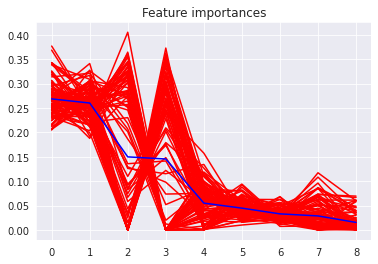

1. feature : Fare (0.268464)
2. feature : Age (0.260022)
3. feature : split_sex_female (0.149643)
4. feature : split_sex_male (0.145338)
5. feature : split_Pclass_3 (0.054979)
6. feature : SibSp (0.044637)
7. feature : Parch (0.032894)
8. feature : split_Pclass_1 (0.028675)
9. feature : split_Pclass_2 (0.015348)


In [81]:
classifier_importance(X, rf)

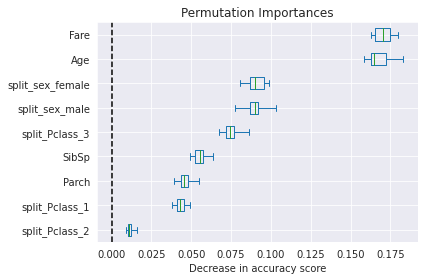

In [83]:
result = permutation_importance(
    rf, X, y, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

## Question 5
Grâce au graphique ci-dessus on constate que Fare et Age sont très fort. Car à une permutation près, le score descend très rapidement. On note le même phénomène avec la variable `Age`.
On note une faible baisse de score pour les autres variables : `Split_sex_male`, `split_Pclass_3`, `split_sex_female`, `SibSp`, `split_Pclass_1`, `Parch`, `split_Pclass_2`.

# Partie 7 : Gradient Boosting

In [86]:
from sklearn.ensemble import GradientBoostingClassifier

def parse_model_6(X):
    target = X.Survived
    to_del = ['Name', 'Cabin', 'Embarked', 'Survived', 'Ticket']
    for col in to_del:
        del X[col]
    return X, target

def fix_missing_value(data):
    X = data.copy()
    X['Age'] = X['Age'].fillna(np.nanmedian(X['Age']))
    class_dummies = pd.get_dummies(X['Pclass'], prefix='split_Pclass')
    X = X.join(class_dummies)
    class_dummies = pd.get_dummies(X['Sex'], prefix='split_sex')
    X = X.join(class_dummies)
    del X['Sex']
    del X['Pclass']
    return X

data = pd.read_csv('./data/titanic_train.csv', sep=',')
data.set_index('PassengerId', inplace=True, drop=True)
data = fix_missing_value(data)
X,y = parse_model_6(data)

print(X.columns)

gb = GradientBoostingClassifier()
gb.fit(X,y)
print(compute_score(gb,X,y))

Index(['Age', 'SibSp', 'Parch', 'Fare', 'split_Pclass_1', 'split_Pclass_2',
       'split_Pclass_3', 'split_sex_female', 'split_sex_male'],
      dtype='object')
0.8237900947837549


## Question 1

On constate une meilleure précision du score de prédiction pour le gradient boosting.
La différence entre random forest et le gradient boosting s'explique par le fait que gradient boosting va construire des arbres un à un et propager les erreurs des arbres precedent (afin d'éviter de refaire la même erreur) contrairement à random forest ou les arbres sont construits indépendamment les uns des autres et qui fait une moyenne des erreurs.